# Electron Study

The aim of this study is to determine whether the introduction of new track properties, namely `chi2rphi` and `chi2rz`, improve the performance of machine learning algorithms dedicated to telling whether electron-labeled track-trigger tracks are real or fake.

The Monte-Carlo samples available are a QCD sample, a Z boson to muon-muon sample, and a Z boson to electron-electron sample. Each sample is run for the D49 detector geometry and contains 1000 events, each of which has a pileup of about 200.

Much of the code here is run using the `ntupledicts` package, which can be found [here](https://github.com/cqpancoast/ntupledicts), along with a simple tutorial that covers all code used here.
The requirements for running this notebook are the same as the ones listed for running `ntupledicts` in the README.

In [1]:
from uproot import open as uproot_open
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dense

from ntupledicts import operations as ndops
from ntupledicts.operations import select as sel
from ntupledicts import plot as ndplot
from ntupledicts.ml import data as ndmldata
from ntupledicts.ml import predict as ndmlpred
from ntupledicts.ml import models as ndmlmodels

## Data Acquisition

Grab tracks from stored ntuples, perform cuts, process into datasets.

In [2]:
# List the ntuples we want data from
input_files = ["eventsets/ZMM_PU200_D49.root",
    "eventsets/ZEE_PU200_D49.root",
    "eventsets/QCD_PU200_D49.root"]

# Create list of uproot event sets for easy data access
event_sets = []
for input_file in input_files:
    event_sets.append(next(iter(uproot_open(input_file).values()))["eventTree"])
    
# What track properties do we want available to play with?
# We can select which ones we want a model to train on
# Build an ntuple dict whose only track type is "trk"
properties_by_track_type = {"trk": ["pt", "eta", "z0", "nstub", "genuine", "matchtp_pdgid",
                                    "chi2", "bendchi2", "chi2rphi", "chi2rz"]}

# Create ntuple dict from event sets
ntuple_dict = ndops.uproot_ntuples_to_ntuple_dict(event_sets, properties_by_track_type)

### Apply Cuts

Ensure there are as many fake tracks as there are real tracks, perform desired cuts on dataset.

In [3]:
# Would we like to consider only a portion of this dataset? (Typically done for speed reasons.)
reduce_ntuple_dict = False
reduction_size = 1000000  # number of tracks to reduce to
if reduce_ntuple_dict:
    ntuple_dict = ndops.reduce_ntuple_dict(ntuple_dict, reduction_size)

# Reduce genuine track size to be equal to fake track size, concatenate and shuffle
# (nd means ntuple_dict)
all_nd_gens = ndops.cut_ntuple_dict(ntuple_dict, {"trk": {"genuine": sel(1)}})
nd_fakes = ndops.cut_ntuple_dict(ntuple_dict, {"trk": {"genuine": sel(0)}})
nd_gens = ndops.reduce_ntuple_dict(all_nd_gens,
                                   track_limit=ndops.track_prop_dict_length(nd_fakes["trk"]),
                                   shuffle_tracks=True,
                                   seed=42)
ntuple_dict = ndops.shuffle_ntuple_dict(ndops.add_ntuple_dicts([nd_gens, nd_fakes]), seed=42)

# Are there any other cuts that should be applied to this dataset?
# additional_cuts = {"trk": {"matchtp_pdgid": sel([sel(11), sel(-11), sel(-999)])}}
    # only select electrons and fakes?
# ntuple_dict = ndops.cut_ntuple_dict(nd_both, additional_cuts)

### Process into Datasets

Process the ntuple dict above into `TrackPropertiesDataset`s.

In [4]:
non_sc2_data_props = ["chi2", "bendchi2", "nstub"]  # properties we want to train our first set of models on?
label_property = "genuine"                          # what property are we trying to predict?
split_list = [.7, .2, .1]                           # how many datasets should we create,
                                                    #   and with what relative sizes?
train_ds, eval_ds, test_ds = ndmldata.TrackPropertiesDataset(ntuple_dict["trk"],
                                                             label_property,
                                                             non_sc2_data_props).split(split_list)

## Making Models

Build two neural networks and two gradient boosted decision trees, train one of them on data containing the split chi2 variables and one of them on data without them. Also define two sets of predictive cuts to compare our models against.

In [5]:
# Make the models without the cuts
NN = ndmlmodels.make_neuralnet(train_ds, eval_dataset=eval_ds, hidden_layers=[15, 8], epochs=10)
GBDT = ndmlmodels.make_gbdt(train_ds)

# These are the properties that we will train the split chi2 set of models
sc2_data_props = ["chi2rphi", "chi2rz", "bendchi2", "nstub"]
for ds in [train_ds, eval_ds, test_ds]:
    ds.set_active_data_properties(sc2_data_props)

# (sc2 stands for split chi2)
NN_sc2 = ndmlmodels.make_neuralnet(train_ds, eval_dataset=eval_ds, hidden_layers=[15, 8], epochs=10)
GBDT_sc2 = ndmlmodels.make_gbdt(train_ds)

# Define predictive cuts
chi2_cuts = {"chi2": sel(0, 21)}
sc2_cuts = {"chi2rphi": sel(0, 23), "chi2rz": sel(0, 7)}

Train on 38162 samples, validate on 10903 samples
Epoch 1/10
38162/38162 [==============================] - 16s 427us/sample - loss: 0.2893 - accuracy: 0.9018 - val_loss: 0.2480 - val_accuracy: 0.9187
Epoch 2/10
38162/38162 [==============================] - 15s 383us/sample - loss: 0.2420 - accuracy: 0.9137 - val_loss: 0.2167 - val_accuracy: 0.9187
Epoch 3/10
38162/38162 [==============================] - 14s 358us/sample - loss: 0.2337 - accuracy: 0.9155 - val_loss: 0.2249 - val_accuracy: 0.9186
Epoch 4/10
38162/38162 [==============================] - 16s 408us/sample - loss: 0.2321 - accuracy: 0.9170 - val_loss: 0.2179 - val_accuracy: 0.9224
Epoch 5/10
38162/38162 [==============================] - 15s 382us/sample - loss: 0.2287 - accuracy: 0.9188 - val_loss: 0.2113 - val_accuracy: 0.9245
Epoch 6/10
38162/38162 [==============================] - 15s 398us/sample - loss: 0.2257 - accuracy: 0.9193 - val_loss: 0.2109 - val_accuracy: 0.9243
Epoch 7/10
38162/38162 [====================

### Model Predictions

Use the test dataset `test_ds` that hasn't been used for training to make predicted labels. These will be probablistic in the case of the models `NN` and `GBDT` and exact in the case of `cuts`. Store these predictions in `test_ds` for easy future access.

In [6]:
# Add normal chi2 predictions
test_ds.add_prediction("NN", ndmlpred.predict_labels(NN, test_ds.get_data(non_sc2_data_props)))
test_ds.add_prediction("GBDT", ndmlpred.predict_labels(GBDT, test_ds.get_data(non_sc2_data_props)))
test_ds.add_prediction("chi2_cuts", ndmlpred.predict_labels_cuts(chi2_cuts, test_ds))

# Add split chi2 predictions
test_ds.add_prediction("NN_sc2", ndmlpred.predict_labels(NN_sc2, test_ds.get_data(sc2_data_props)))
test_ds.add_prediction("GBDT_sc2", ndmlpred.predict_labels(GBDT_sc2, test_ds.get_data(sc2_data_props)))
test_ds.add_prediction("sc2_cuts", ndmlpred.predict_labels_cuts(sc2_cuts, test_ds))

## Plotting Model Predictions

Now we'll compare the two sets of predictions to see which ones perform better. These plots will measure the true positive rate and false positive rate (TPR and FPR) of these predictions with respect to various threshhold values and track properties.

In [22]:
from ntupledicts.ml import plot as ndmlplot
from matplotlib.pyplot import cla, sca, gca, show

These import statement is down here for debug purposes - so we don't have to rerun all the cells to change something in `ml.plot` suite or add some new `matplotlib` import.

In [23]:
# Selectors for different particle types.
el_sel = sel([sel(11), sel(-11)])
muon_sel = sel([sel(13), sel(-13)])
fake_sel = sel(-999)
hadron_sel = sel([el_sel, muon_sel, fake_sel], invert=True)  # "everything else"

### ROC Curve

Plot the models' paths through TPR/FPR space as the threshhold on probablistically predicted labels changes. Also includes the cuts' point in that space.

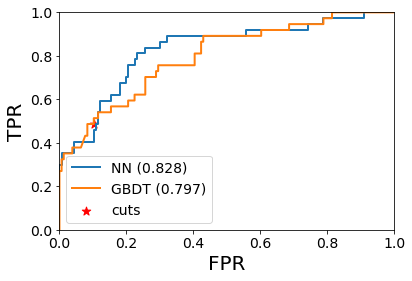

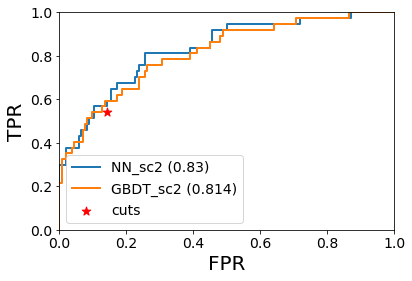

In [14]:
xlims=(0, 1)
ylims=(0, 1)

ndmlplot.plot_rocs(test_ds.cut(el_sel), ["NN", "GBDT"], ["chi2_cuts"], xlims=xlims, ylims=ylims)
ndmlplot.plot_rocs(test_ds.cut(el_sel), ["NN_sc2", "GBDT_sc2"], ["sc2_cuts"], xlims=xlims, ylims=ylims)

### Particle TPR and FPR by Threshhold

Plot TPR and FPR for particles of a particular type as the threshhold for assigning probablistic values to either genuine or not genuine shifts from zero to one. Make plots for both sets of models to compare performance.

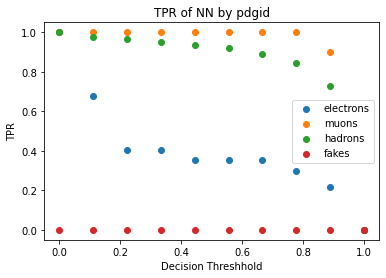

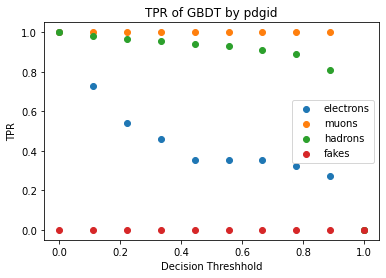

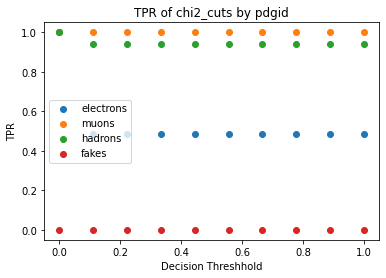

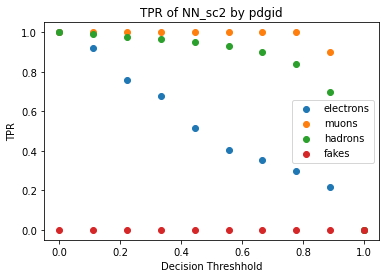

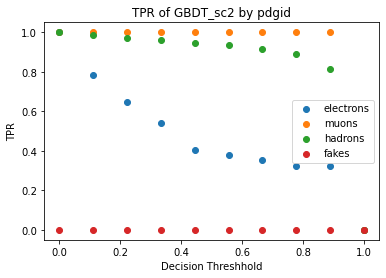

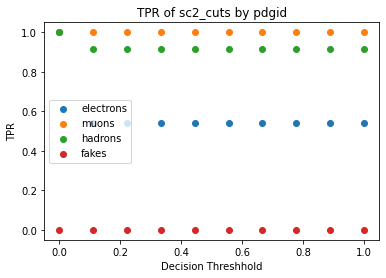

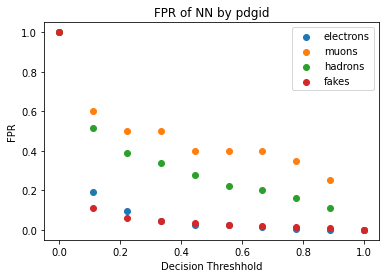

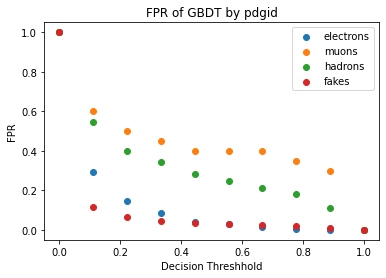

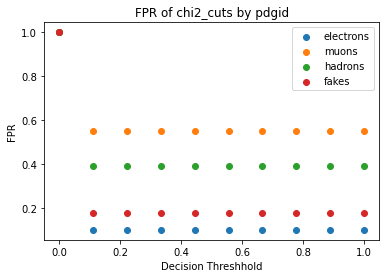

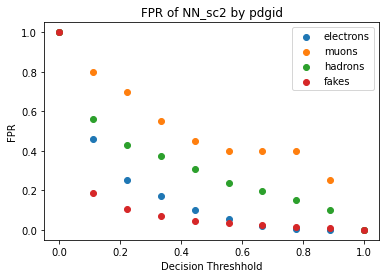

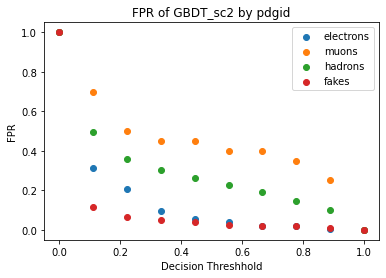

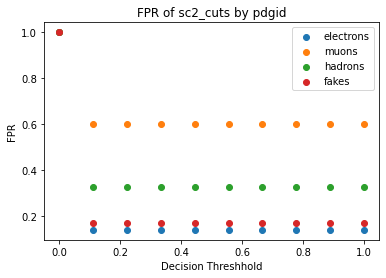

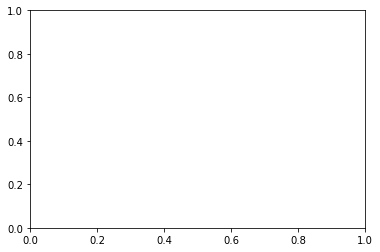

In [24]:
# TPR/FPR vs decision thresh * models, ov. particle type
for pred_comparison, pred_comp_name in zip(
        [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
        ["TPR", "FPR"]):
    for pred_name in test_ds.get_all_prediction_names():
        ax = gca()
        for pdgid_sel, particle_type in zip(
                [el_sel, muon_sel, hadron_sel, fake_sel],
                ["electrons", "muons", "hadrons", "fakes"]):
            test_ds_pdgid = test_ds.cut({"matchtp_pdgid": pdgid_sel})
            ax = ndmlplot.plot_pred_comparison_by_threshhold(test_ds_pdgid,
                    pred_name, pred_comparison, legend_id=particle_type, ax=ax)
        ax.set_ylabel(pred_comp_name)
        ax.set_title("{} of {} by pdgid".format(pred_comp_name, pred_name))
        ax.legend()
        plt.show()
        cla()

### Particle TPR and FPR by Track Property

Plot TPR and FPR for particles of a particular type for binned values of some track property. The aim of this is to get a sense of how model performance depends upon track properties like pT and eta. Make plots for both sets of models to compare performance.

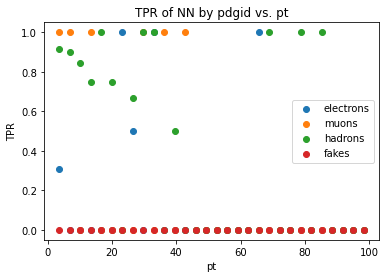

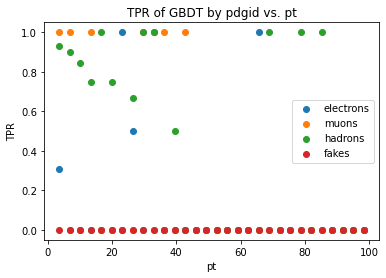

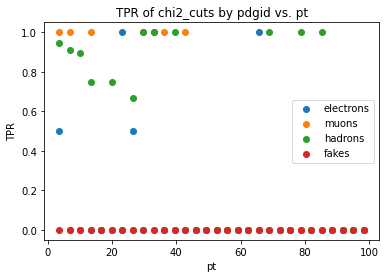

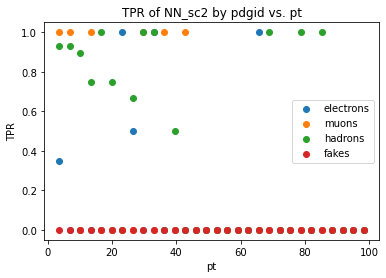

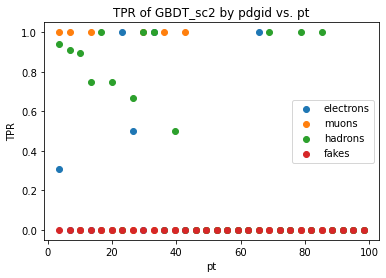

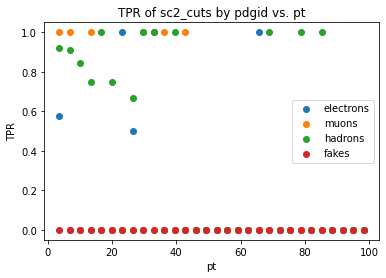

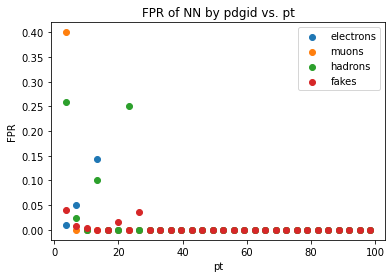

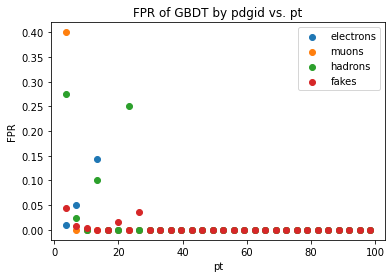

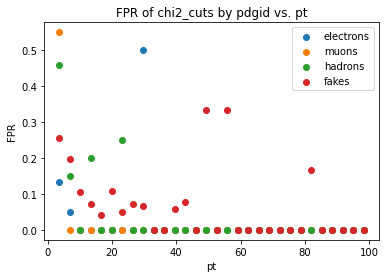

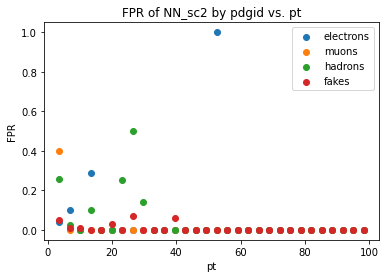

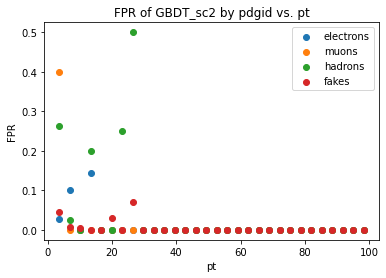

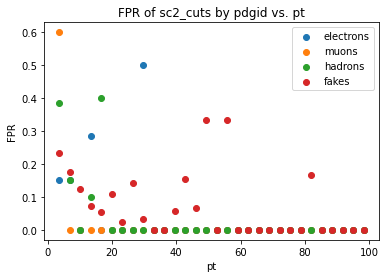

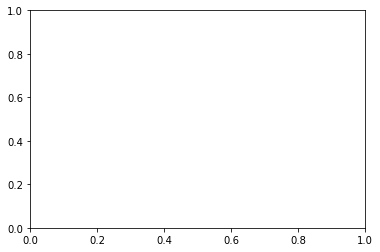

In [25]:
# TPR/FPR vs some track prop * models, ov. particle type.
# Parametrized by binning property.

# A dictionary from track properties to bin specifiers
binning_dict = {"pt": (2, 100, 30)}

for binning_prop, bins in zip(binning_dict.keys(), binning_dict.values()):
    for pred_comparison, pred_comp_name in zip(
            [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
            ["TPR", "FPR"]):
        for pred_name in test_ds.get_all_prediction_names():
            ax = gca()
            for pdgid_sel, particle_type in zip(
                    [el_sel, muon_sel, hadron_sel, fake_sel],
                    ["electrons", "muons", "hadrons", "fakes"]):
                pdgid_sel_dict = {"matchtp_pdgid": pdgid_sel}
                test_ds_pdgid = test_ds.cut(pdgid_sel_dict)
                ax = ndmlplot.plot_pred_comparison_by_track_property(
                        test_ds_pdgid, pred_name,
                        pred_comparison, binning_prop, bins=bins,
                        legend_id=particle_type, ax=ax)
            ax.set_ylabel(pred_comp_name)
            ax.set_title("{} of {} by pdgid vs. {}".format(pred_comp_name, pred_name, binning_prop))
            ax.legend()
            plt.show()
            cla()

## Takeaways

Bacon ipsum dolor amet...